## <b>Style Transfer Tutorial</b>

* 원본 논문: [Image Style Transfer Using Convolutional Neural Networks (CVPR 2016)](https://rn-unison.github.io/articulos/style_transfer.pdf)
* 딥러닝을 활용한 <b>스타일 전송(style transfer)</b> 방법을 처음으로 제안한 논문입니다.
    * 이미지 자체를 업데이트하는 이미지 최적화(optimization) 기법 유형에 해당합니다.
* 소스코드를 실행하기 전에 **[런타임]** - **[런타임 유형 변경]** - **[GPU]**로 설정되어 있는지 확인합니다.
* 논문에서 제시한 파라미터를 완전히 동일하게 따르지는 않으며 핵심 아이디어를 이해하는 목적에 적합한 코드입니다.

#### <b>실습에 필요한 라이브러리 불러오기 및 환경 설정</b>

In [1]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [2]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = PIL.Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    # print(image.shape)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

In [4]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 462, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 462 (delta 73), reused 7 (delta 2), pack-reused 261
Receiving objects: 100% (462/462), 53.82 MiB | 30.79 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/Deep-Learning-Paper-Review-and-Practice


#### <b>Image Reconstruction 실습하기</b>

* 이미지를 최적화(optimization)한다는 것은 특정 손실 값을 낮추는 방향으로 이미지를 업데이트하는 것을 의미합니다.
* MSE 손실(loss)을 이용해 임의의 노이즈(noise)를 특정한 이미지로 변환해 봅시다.

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7FB8A87B1550>


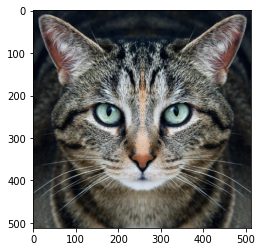

In [19]:
# 목표 이미지(target image) 불러오기
img_path = './code_practices/images/cat.jpg'
target_image = image_loader(img_path, (512, 512))
imshow(target_image)

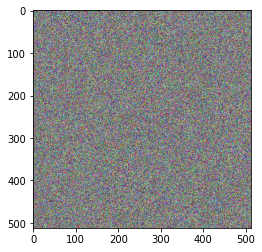

In [6]:
# 동일한 크기의 노이즈 이미지 준비하기
noise = torch.empty_like(target_image).uniform_(0, 1).to(device)
imshow(noise)

[ Start ]


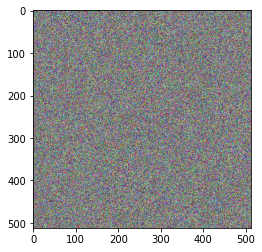

[ Step: 10 ]
Loss: 0.10447775572538376


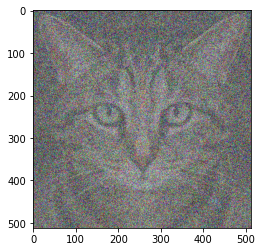

[ Step: 20 ]
Loss: 0.06241267919540405


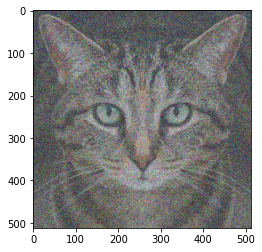

[ Step: 30 ]
Loss: 0.037283945828676224


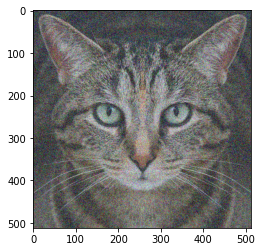

[ Step: 40 ]
Loss: 0.02227260172367096


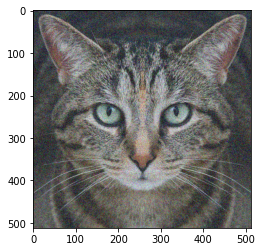

[ Step: 50 ]
Loss: 0.013305154629051685


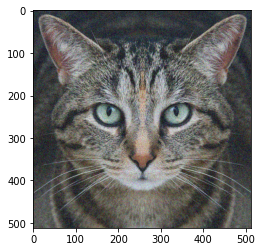

[ Step: 60 ]
Loss: 0.007948203943669796


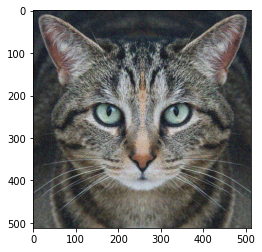

[ Step: 70 ]
Loss: 0.004748079925775528


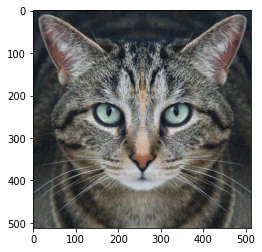

[ Step: 80 ]
Loss: 0.002836397150531411


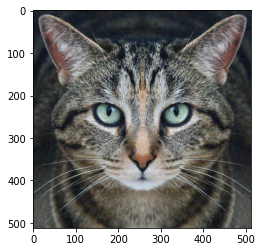

[ Step: 90 ]
Loss: 0.0016944004455581307


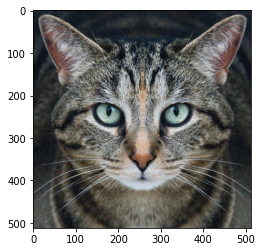

[ Step: 100 ]
Loss: 0.0010121972300112247


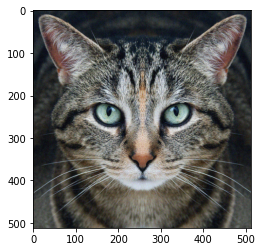

In [7]:
loss = nn.MSELoss() # 손실(loss) 함수 설정
iters = 100 # 반복(iteration) 횟수 설정
lr = 1e4

print("[ Start ]")
imshow(noise)

for i in range(iters):
    # required_grad 속성의 값을 True로 설정하여 해당 torch.Tensor의 연산을 추적
    noise.requires_grad = True

    # 손실 함수에 대하여 미분하여 기울기(gradient) 계산
    output = loss(noise, target_image)
    output.backward()

    # 계산된 기울기(gradient)를 이용하여 손실 함수가 감소하는 방향으로 업데이트
    gradient = lr * noise.grad
    # 결과적으로 노이즈(perturbation)의 각 픽셀의 값이 [-eps, eps] 사이의 값이 되도록 자르기
    noise = torch.clamp(noise - gradient, min=0, max=1).detach_() # 연산을 추적하는 것을 중단하기 위해 detach() 호출

    if (i + 1) % 10 == 0:
        print(f'[ Step: {i + 1} ]')
        print(f'Loss: {output}')
        imshow(noise)

#### <b>실습을 위한 이미지 불러오기</b>

* 빈센트 반 고흐의 그림과 건물 사진을 불러옵니다.

[ Content Image ]


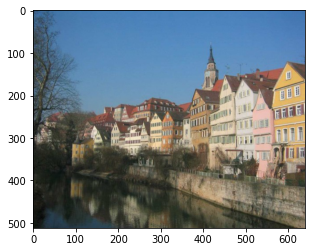

[ Style Image ]


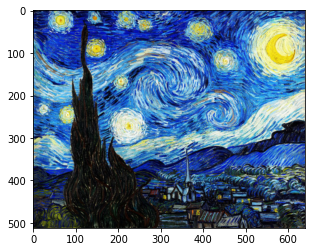

In [11]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

#### <b>CNN 네트워크 불러오기</b>

* 특징 추출기(feature extractor)로 VGG 네트워크를 사용합니다.

In [12]:
# 뉴럴 네트워크 모델을 불러옵니다.
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
# 입력 정규화(Normalization)를 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

#### <b>Style Reconstruction 실습하기</b>

* 임의의 노이즈(noise)가 특정한 이미지의 스타일을 가지도록 변환합니다.
* style_layers 리스트 변수의 값을 조절하여 어떤 레이어를 이용할지 설정할 수 있습니다.

In [ ]:
def gram_matrix(input):
    # a는 배치 크기, b는 특징 맵의 개수, (c, d)는 특징 맵의 차원을 의미
    a, b, c, d = input.size()
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    features = input.view(a * b, c * d)
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * b * c * d)


# 스타일 손실(style loss) 계산을 위한 클래스 정의
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input